# Анализ поведения пользователей в мобильном приложении

<b>Содержание</b>
<a id=0> </a>

[Введение](#1)  
[Предобработка данных](#2)  
[Исследовательский анализ](#3)  
[Метрики](#4)  
[Гипотезы](#5)  
[Вывод](#6)

## Введение
<a id=1> </a>

В нашем распоряжении данные источников установки приложения и данные логов из мобильного приложения. Требуется проанализировать данные и установить связь целевого события - просмотра контактов - с другими дейсвиями пользователей. Информация о поведении пользователей и пользовательских сценариях должна помочь улучшить пользовательский опыт, привлечь новых пользователей.


**Задачи**

1. Определить сценарии действий, с помощью которых в дальнейшем заказчик сможет сегментировать пользователей.
0. Определить, какие действия чаще совершают те пользователи, которые просматривают контакты.
0. Посмотреть, как различается время между распространенными событиями.
3. Узнать, какие события совершают пользователи перед целевым.
4. Проверить основную гипотезу: одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`. Конверсия в просмотры контактов различается у этих двух групп.
5. Проверить дополнительную гипотезу: пользователи, совершившие действие `favorites_add` лучше конвертируются в целевое действие, чем те у кого его нет.   

## Предобработка данных
<a id=2> </a>

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import math as mth
from scipy import stats as st

import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MultipleLocator


import seaborn as sns
from plotly import graph_objects as go 

import warnings


In [3]:
# загружаем данные
sources = pd.read_csv('--')
users = pd.read_csv('--')
display(sources)
users

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


Будем работать с каждым датафреймом по-очереди. Для начала изменим названия столбцов на привычные.

In [4]:
# переименуем колонки
sources.columns=['user_id', 'source']
sources

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


### Проверка на пропуски и дубликаты

Проверим на пропуски и дубликаты

In [5]:
sources.duplicated().sum()

0

In [6]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Пропусков и дубликатов не обнаружено.

Проделаем те же операции со вторым датасетом.

In [7]:
# переименуем колонки
users.columns = ['event_time', 'event_name', 'user_id']
users

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


In [8]:
users.duplicated().sum()


0

In [9]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Пропусков и дубликатов не обнаружено.  
Приведем дату к формату  datetime.

In [10]:
# поменяем формат времени, округлим секунды.
users['event_time'] = pd.to_datetime(users['event_time'], format = '%Y-%m-%dT%H:%M:%S').round('1s')
users


,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:30,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


У нас есть один и тот же тип события, названные по-разному: `show_contact` и `contact_show`. Поскольку это одно и то же событие, сделаем их одним.

In [11]:
def rename_event(col): # напишем функцию, которая заменит название события
    event_name = col['event_name']
    if event_name == 'show_contacts':
        return 'contacts_show'
    elif event_name == 'contacts_show':
        return 'contacts_show'
    return event_name
users['event_name'] = users.apply(rename_event, axis=1) # применим нашу функцию


Данные по разным видам поиска объединим в один. Пока что нам не важна разница между ними.

In [12]:
users['event_name'] = users['event_name'].str.replace('search_+\d', 'search', regex=True)
users['event_name'].unique() # проверим

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

Для удобства объединим оба датасета в один.

In [13]:
data = users.merge(sources, how='outer', on='user_id')
data

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
...,...,...,...,...
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google


In [14]:
data.to_csv('mobile_data.csv', index=False) # сохраним базу в csv-файл

Проверим итоговый датасет на наличие дубликатов еще раз. Они могли появиться из-за переименований столбцов.

In [15]:
data.duplicated().sum()

1190

In [16]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Насколько полные наши данные?

Какой период времени содержится в наших данных?

In [17]:
display(data['event_time'].min()) # минимальная дата
data['event_time'].max() # максимальная дата

Timestamp('2019-10-07 00:00:00')

Timestamp('2019-11-03 23:58:13')

У нас данные с 7 октября 2019 по 3 ноября 2019 то есть примерно 4 недели.

Изучим пользовательскую активность за весь период.

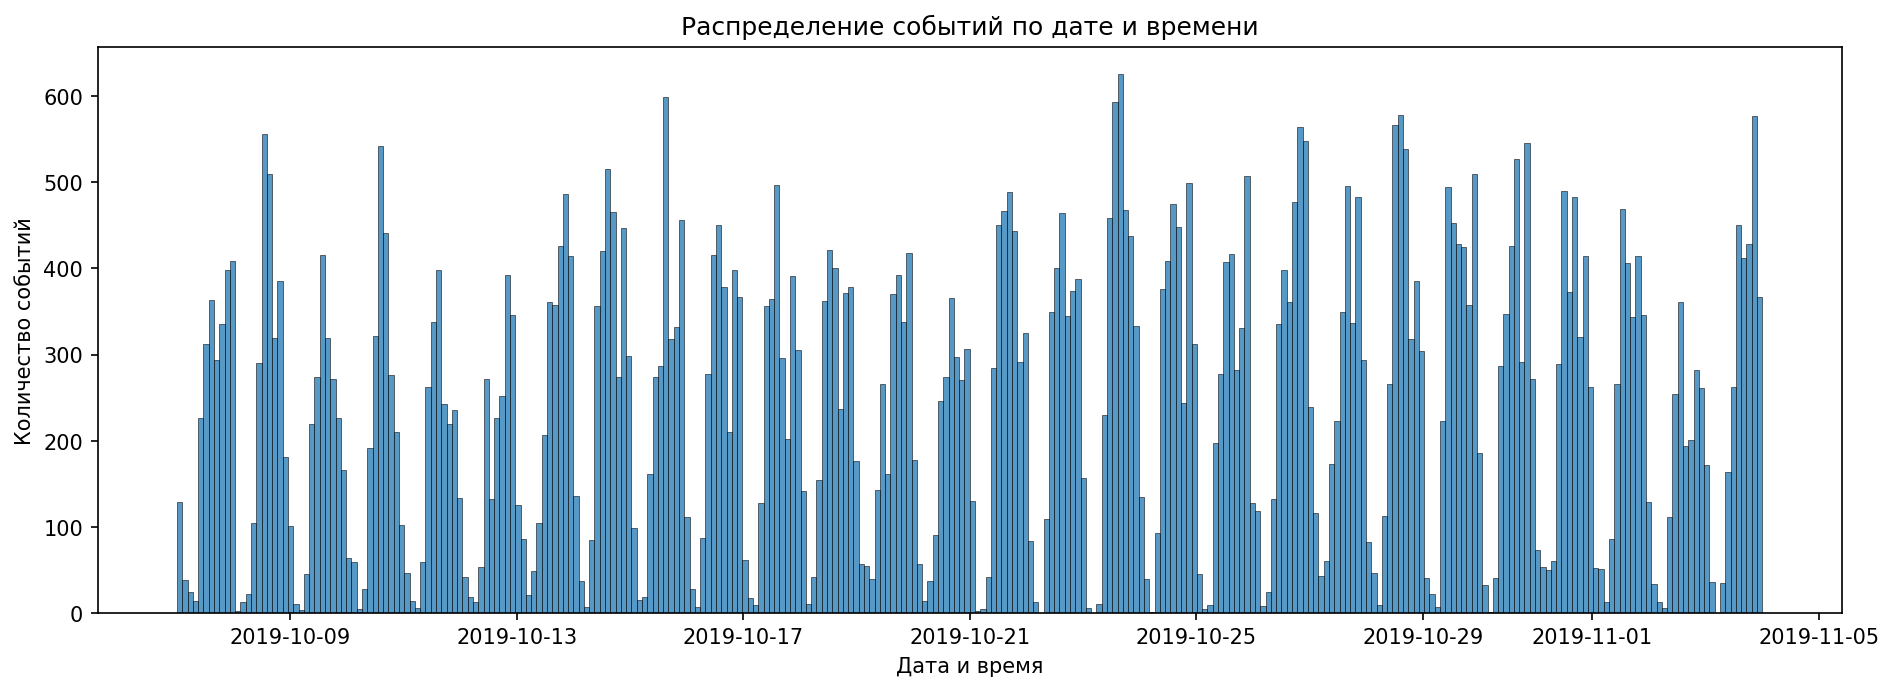

In [18]:
# построим гистограмму распределения событий по дням
fig, ax=plt.subplots(figsize=(15, 5), dpi=150)
ax=sns.histplot(data=data, x='event_time', bins=300)
plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.savefig('count_events.png');

Видим, что данные полные за весь исследуемый период, распределение нормальное, с пиками днем и провалами ночью.

Первоначальная обработка данных завершена, мы привели их в порядок, проверили на наличие пропусков и ошибок, поменяли формат даты-времени. Можно преступать к исследовательскому анализу.

[Содержание](#0)

## Исследовательский анализ
<a id=3> </a>

### События 

Посмотрим, какие вообще события содержатся в логе? 

In [19]:
data['event_name'].value_counts()

tips_show        39892
photos_show       9372
search            6694
advert_open       6145
contacts_show     4381
map               3760
favorites_add     1414
tips_click         811
contacts_call      538
Name: event_name, dtype: int64

Самые распространенные события - просмотр рекомендованных объявлений, скорее всего они выглядят как лента, и - просмотр фотографий выбранного объявления, далее идет раскрытие объявления и просмотр контактов. Все складывается в неплохую воронку и похоже на сценарий действий. Но он может быть не один. 

Для того, чтобы посмотреть возможные сценарии, нам нужно разделить действия пользователей на сессии. За сессию будет считать 1 день.

In [20]:
# выполним сортировку по времени события, чтобы сессии собрались из стоящих рядом событий
data = data.sort_values(['user_id', 'event_time'])
# разделим сессии по дням
g = (data.groupby('user_id')['event_time'].diff() > pd.Timedelta(5, 'h')).cumsum()
# запишем результат в отдельную колонку
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1
data.head(20)

,event_time,event_name,user_id,source,session_id
2171,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2172,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2173,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2174,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2175,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2176,2019-10-07 13:45:43,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2177,2019-10-07 13:46:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2178,2019-10-07 13:47:33,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2179,2019-10-07 13:49:42,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2180,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2


Отлично! У нас есть сессии, каждая из которых представляет собой сценарий действий пользователя, иначе говоря - воронку событий. Тепреь нужно понять, какие вообще сцерарии бывают, какие сценарии - наиболее распространенные и главное - какие из сценариев приводят к целевому действию, просмотру контактов.

In [21]:
# сгруппируем по id сессии и выделим последовательность уникальных событий в каждой
sessions=data.groupby('session_id').agg(event_unique=('event_name', 'unique')).reset_index()
sessions

,session_id,event_unique
0,1,[tips_show]
1,2,"[map, tips_show]"
2,3,"[tips_show, map]"
3,4,"[map, tips_show]"
4,5,"[search, photos_show]"
...,...,...
8237,8238,[tips_show]
8238,8239,[tips_show]
8239,8240,[tips_show]
8240,8241,"[tips_show, contacts_show]"


In [22]:
# превратим данные о событиях в строки
sessions['event_unique'] = sessions['event_unique'].apply(lambda x: str(x))
# посмотрим на самые популярные цепочки событий
sessions['event_unique'].value_counts().head(25)


['tips_show']                                 1830
['photos_show']                                944
['search']                                     559
['map' 'tips_show']                            481
['search' 'photos_show']                       477
['search' 'tips_show']                         366
['tips_show' 'contacts_show']                  245
['tips_show' 'map']                            187
['map' 'advert_open' 'tips_show']              153
['tips_show' 'tips_click']                     143
['contacts_show']                              124
['photos_show' 'search']                       103
['advert_open']                                 96
['search' 'map' 'tips_show']                    96
['map']                                         91
['advert_open' 'tips_show']                     85
['map' 'tips_show' 'contacts_show']             85
['search' 'map' 'advert_open' 'tips_show']      79
['photos_show' 'contacts_show']                 75
['contacts_show' 'contacts_call

Можно выделить несколько самых распространенных сценариев, приводящих к целевому действию:
- просмотр рекомендаций, `просмотр контактов`
- карта, просмотр рекомендаций, `просмотр контактов`
- поиск, просмотр фото, `просмотр контактов`

И другие распространенные сценарии, но идущие по другому пути:
- поиск, карта, просмотр рекомендаций
- поиск, карта, открытие карточки объявления, просмотр рекомендаций
- карта, открытие карточки объявления, просмотр рекомендаций


Заметим, что у нас 2 окончания цепочки - пользователи либо заканчивают сценарий просмотром контактов, либо возвращаются к прсмотру рекомендаций.
Так же можно сказать, что большая часть пользователей просто "зашли посмотреть".  


### Построение воронки событий

Как видим из данных, у нас нет какой-либо одной воронки событий, но есть несколько сценариев, визуализируем их для наглядности.

In [23]:
data.head(5)

,event_time,event_name,user_id,source,session_id
2171,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2172,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2173,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2174,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2175,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1


#### Воронки, ведущие к целевому событию

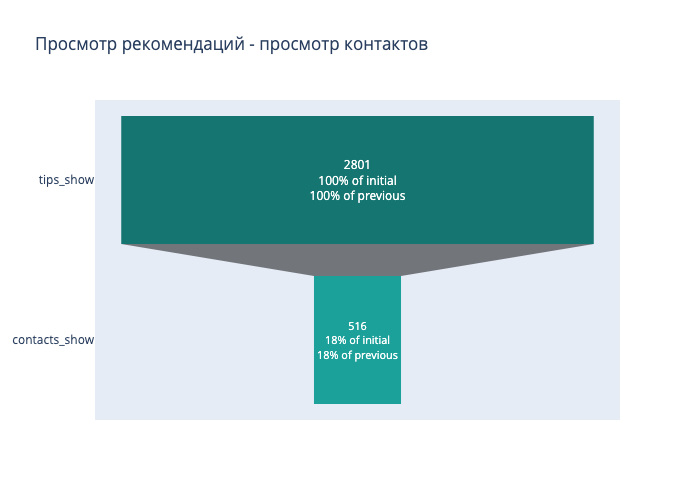

Конверсия в целевое действие составила 18.4%


In [24]:
def funnel(events_list, users_list, title):
    fig = go.Figure(
        go.Funnel(
            y=events_list,
            x=users_list,
            textinfo = "value+percent initial+percent previous", marker = {"color":
                          ['#157570', '#1CA09A', '#23C7BF', '#70E6E0']}
        )
    )
    fig.update_layout(title_text= title)
    fig.show('png')
    print('Конверсия в целевое действие составила {}%'.format(round(users_list[-1]/users_list[0]*100, 1)))
list_1 = data.query('event_name == "tips_show"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name=="contacts_show"')['user_id'].unique()
          
users_list = [len(list_1), len(list_2)]

funnel(
    ['tips_show', 'contacts_show'], 
    users_list,
    'Просмотр рекомендаций - просмотр контактов')



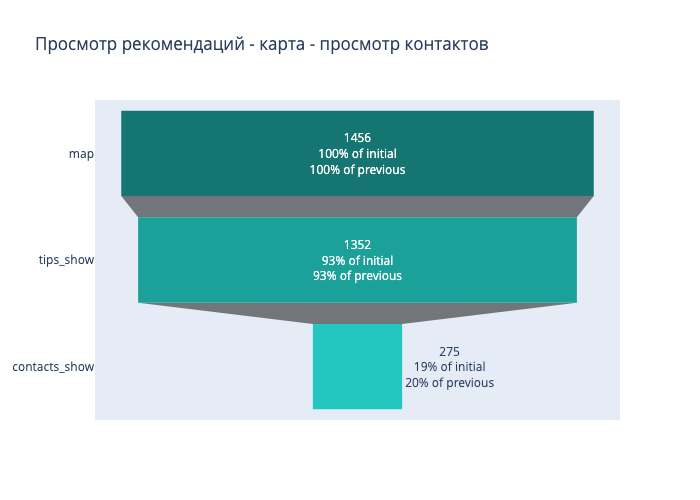

Конверсия в целевое действие составила 18.9%


In [25]:
list_1 = data.query('event_name == "map"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name == "tips_show"')['user_id'].unique()
list_3 = data.query('user_id in @list_2 and event_name == "contacts_show"')['user_id'].unique()          
users_list = [len(list_1), len(list_2), len(list_3)]
funnel(
    ['map','tips_show','contacts_show'], 
    users_list,
    'Просмотр рекомендаций - карта - просмотр контактов')

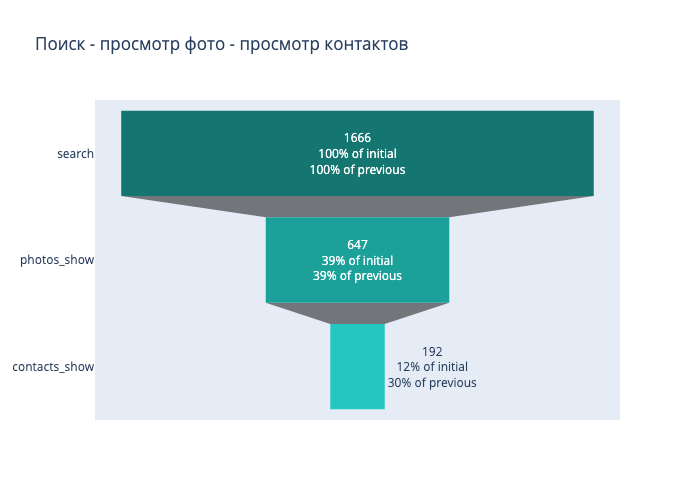

Конверсия в целевое действие составила 11.5%


In [26]:
list_1 = data.query('event_name == "search"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name == "photos_show"')['user_id'].unique()
list_3 = data.query('user_id in @list_2 and event_name == "contacts_show"')['user_id'].unique()          
users_list = [len(list_1), len(list_2), len(list_3)]
funnel(
    ['search', 'photos_show','contacts_show'], 
    users_list,
    'Поиск - просмотр фото - просмотр контактов')


#### Другие распространенные воронки

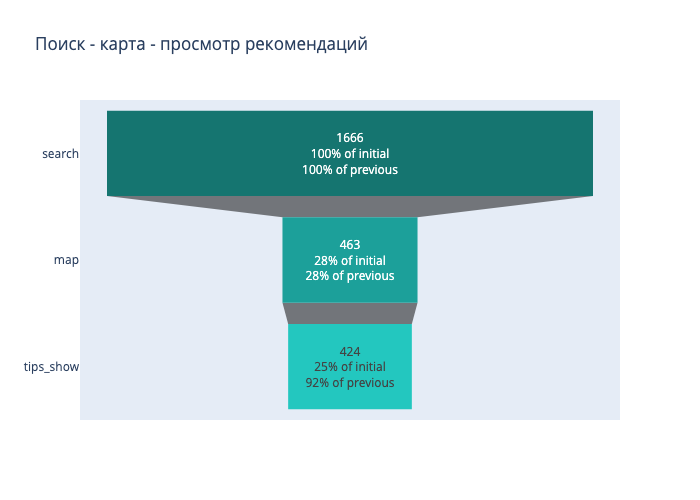

Конверсия в целевое действие составила 25.5%


In [27]:
list_1 = data.query('event_name == "search"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name == "map"')['user_id'].unique()
list_3 = data.query('user_id in @list_2 and event_name == "tips_show"')['user_id'].unique()          
users_list = [len(list_1), len(list_2), len(list_3)]
funnel(
    ['search', 'map','tips_show'], 
    users_list,
    'Поиск - карта - просмотр рекомендаций')

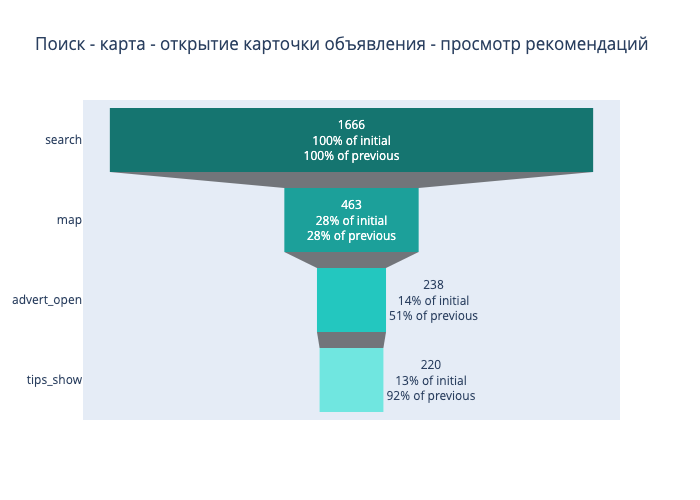

Конверсия в целевое действие составила 13.2%


In [28]:
list_1 = data.query('event_name == "search"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name == "map"')['user_id'].unique()
list_3 = data.query('user_id in @list_2 and event_name == "advert_open"')['user_id'].unique()
list_4 = data.query('user_id in @list_3 and event_name == "tips_show"')['user_id'].unique() 

users_list = [len(list_1), len(list_2), len(list_3), len(list_4)]
funnel(
    ['search', 'map', 'advert_open','tips_show'], 
    users_list,
    'Поиск - карта - открытие карточки объявления - просмотр рекомендаций')

Эта воронка очень похожа на предыдущую, но тут всего 13.2% вернулись к просмотру рекомендаций, а на прошлом сценарии, когда не было дополнительного открытия карточки объявления - 25.5% вернулись к дальшешему просмотру объявлений.

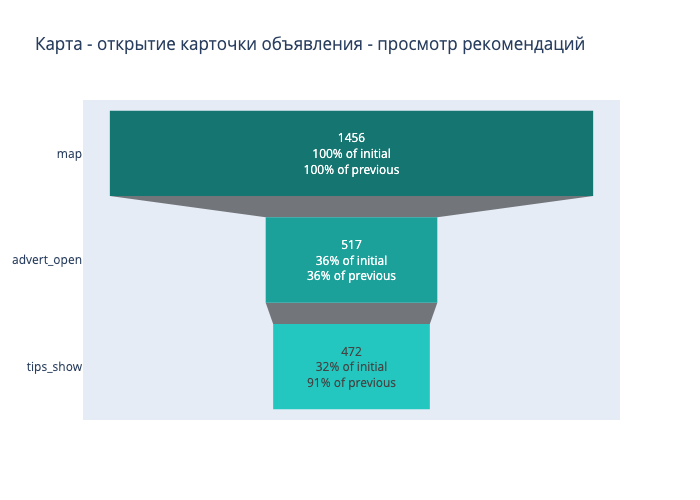

Конверсия в целевое действие составила 32.4%


In [29]:
list_1 = data.query('event_name == "map"')['user_id'].unique()
list_2 = data.query('user_id in @list_1 and event_name == "advert_open"')['user_id'].unique()
list_3 = data.query('user_id in @list_2 and event_name == "tips_show"')['user_id'].unique()

users_list = [len(list_1), len(list_2), len(list_3)]
funnel(
    ['map', 'advert_open','tips_show'], 
    users_list,
    'Карта - открытие карточки объявления - просмотр рекомендаций')

Мы выяснили что пользователи идут по 2 основным сценарием, они либо просмотривают объявления, изучают рекомендации и переходят к просмотру контактов, либо делают то же самое и возвращаются к дальнейшему просмотру объявлений.

### Подсчет времени между распространенными событиями 

Посмотрим, сколько времени проходит между событиями пользователей внутри сессий. Это поможет нам определить, нет ли "застревания" на каком-либо этапе.

Чтобы понять, какие признаки рассматривать, построим тепловую карту корреляций.

In [30]:
# соберем признаки в таблицу
events = data.pivot_table(columns='event_name', index='session_id', values = 'user_id', aggfunc='count')
events

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
session_id,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,12.0
4,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.0
5,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


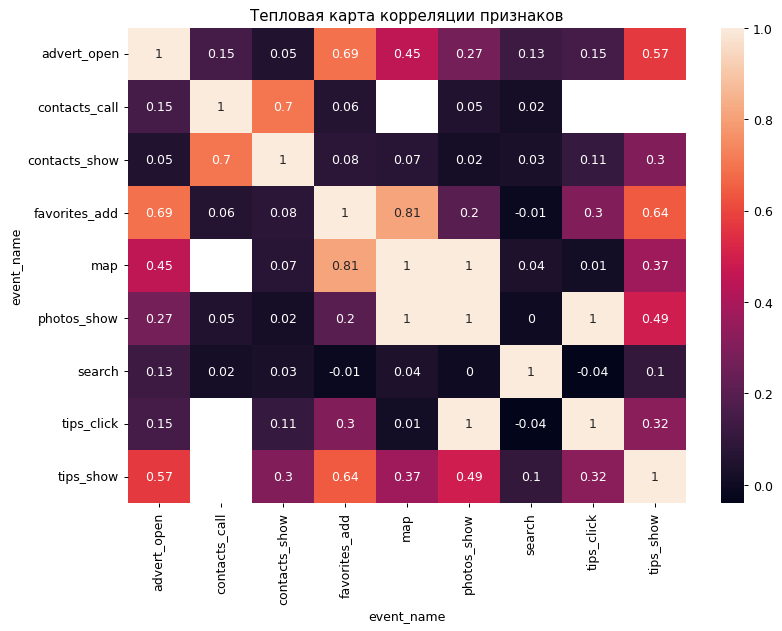

In [31]:
events = round(events.corr(), 2)

fig, ax = plt.subplots(figsize=(10, 7), dpi=90)

# нарисуем тепловую карту с подписями для матрицы корреляций
ax = sns.heatmap(events, annot=True)
plt.title('Тепловая карта корреляции признаков');
plt.savefig('heatmap_corr.png')

100% корреляция тут не так интересна - скорее всего фото показывается автоматически при нажатии на объявление.  
Другие наиболее коррелирующие события:
- просмотр карты - добавление в избранное,
- просмотр карты - просмотр фото (тут они тоже скорее всего отображаются автоматически)
- открытие объявления - добавление в избранное
- показ рекомендаций - открытие объявления

Посмотрим на время между этими событиями, скорее всего, если между ними проходит большое количество времени - крреляция не однозначна.

Напишем функцию, которая будет выводить таблицу с временем совершения первого и второго события.


In [32]:

def time_between(e_1, e_2):
    # выделим сессии, в которых встречаются оба события
    event_1 = data[data['event_name'] == e_1] # отделим событие 1
    list_1 = event_1['session_id'].unique()
    event_2 = data[data['event_name'] == e_2] # отделим событие '2
    list_2 = event_2['session_id'].unique()

    events_list = set(list(set(list_1) & set(list_2))) # найдем пересечение событий
    event1_event2 = data[data['session_id'].isin(events_list)] # отфильтруем по списку

    # а теперь еще удалим лишние события из датасета, они не нужны нам в исследовании
    event1_event2 = event1_event2.query('event_name == @e_1 | event_name == @e_2')
    
    # найдем минимальную дату первого события внутри сессии и минимальную дату второго события
    event1_event2 = pd.pivot_table(event1_event2, values ='event_time', index ='session_id',columns ='event_name', aggfunc='min')
    
    # обработаем датасет, удалив из него события в обратной последовательности.
    # соберем разницу в отдельную колонку
    event1_event2['diff'] = event1_event2[e_2]-event1_event2[e_1] 
    # удалим лишние строки
    event1_event2.drop(event1_event2[event1_event2[e_1] > event1_event2[e_2]].index, inplace = True)
    # переведем интервал в секунды
    event1_event2['diff'] = event1_event2['diff'].apply(lambda x: x.total_seconds())
    return event1_event2

#### Карта - добавление в избранное `map` - `favorites_add`


Теперь можем просто воспользоваться нашей функцией и найти среднее время между интересцющими нас событиями в минутах

In [33]:
map_favorites = time_between('map', 'favorites_add')

print('Медианное время между просмотром карты и добавлением в избранное: {} минут'.format(round(map_favorites['diff'] / 60, 1).median()))


Медианное время между просмотром карты и добавлением в избранное: 11.25 минут


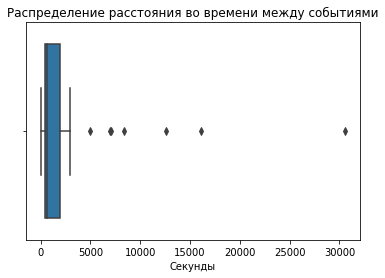

In [34]:
# построим диаграмму боксплот
sns.boxplot(data=map_favorites, x= 'diff')
plt.title('Распределение расстояния во времени между событиями')
plt.xlabel('Секунды');

В данные попали выбросы, которые искажают картину и не дают построить диаграмму распределения. Посмотрим, где они и отбросим хвост.

Проверим персентили, чтобы понять, сколько данных мы можем отбросить.

In [35]:
# найдем 95 персентиль
perc_95 = np.percentile(map_favorites['diff'], 95)

print('Меньше 5% данных составляют время {} минут'.format(round(perc_95/60,1)))

Меньше 5% данных составляют время 171.4 минут


5% выбросов - это расстояние между событиями в более чем 2,8 часа. Отбросим этот хвост.


In [36]:
map_favorites = map_favorites.query('diff < @perc_95')


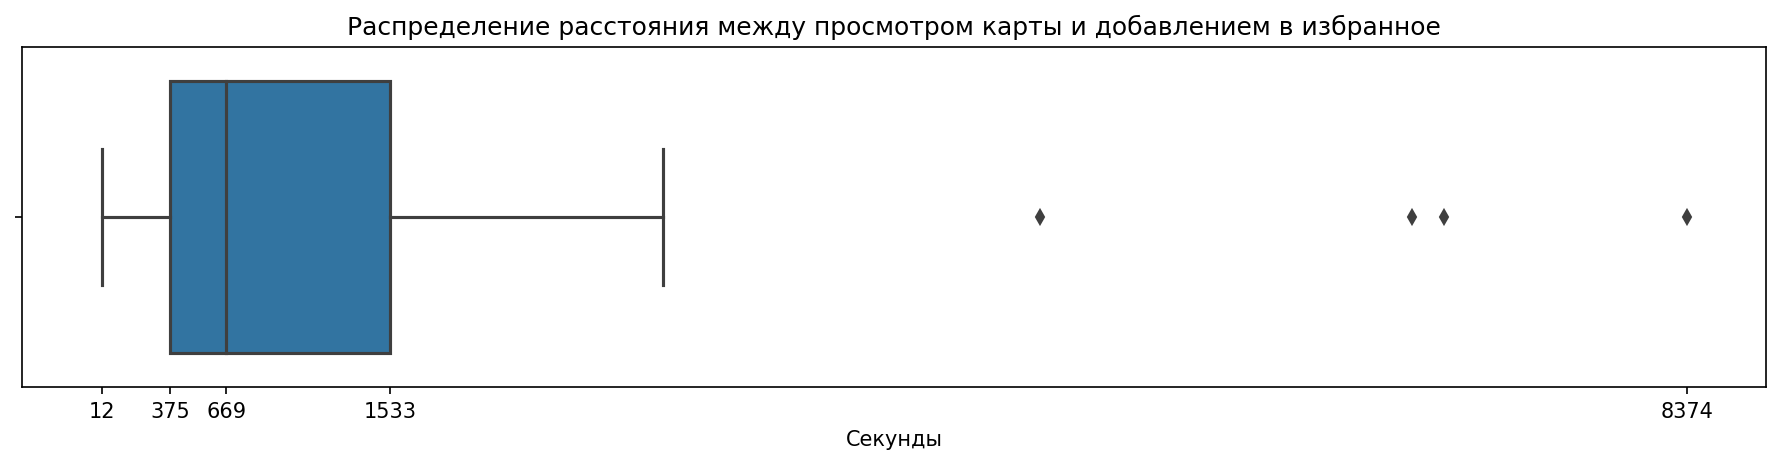

In [37]:
# построим диаграмму боксплот
fig, ax=plt.subplots(figsize=(15, 3), dpi=150)

ax = sns.boxplot(data=map_favorites, x= 'diff')
quantiles = np.quantile(map_favorites['diff'], np.array([0.00, 0.25, 0.50, 0.75, 1]))
ax.set_xticks(quantiles)

plt.title('Распределение расстояния между просмотром карты и добавлением в избранное')
plt.xlabel('Секунды');

Разброс значений находится в промежутке от 5 до 25 минут.

In [38]:
print('Медианное время между просмотром карты и добавлением в избранное: {} минут'.format(round(map_favorites['diff'] / 60, 1).median()))

Медианное время между просмотром карты и добавлением в избранное: 11.2 минут


#### Открытие объявления - добавление в избранное `advert_open` - `favorites_add`

In [39]:
open_favorites = time_between('advert_open', 'favorites_add')

print('Медианное время между открытием объявления и добавлением в избранное: {} минут'.format(round(open_favorites['diff'].median()/ 60, 1)))

Медианное время между открытием объявления и добавлением в избранное: 14.7 минут


In [40]:
print('Медианное время между открытием объявления и добавлением в избранное: {} минут'.format(round(open_favorites['diff'].median()/ 60, 1)))

Медианное время между открытием объявления и добавлением в избранное: 14.7 минут


In [41]:
# найдем 95 персентиль
perc_95 = np.percentile(open_favorites['diff'], 95)
print('Меньше 5% данных составляют время {} минут'.format(round(perc_95/60,1)))

Меньше 5% данных составляют время 131.6 минут


5% выбросов - это расстояние между событиями в более чем полтора часа. Отбросим этот хвост.


In [42]:
open_favorites = open_favorites.query('diff < @perc_95')


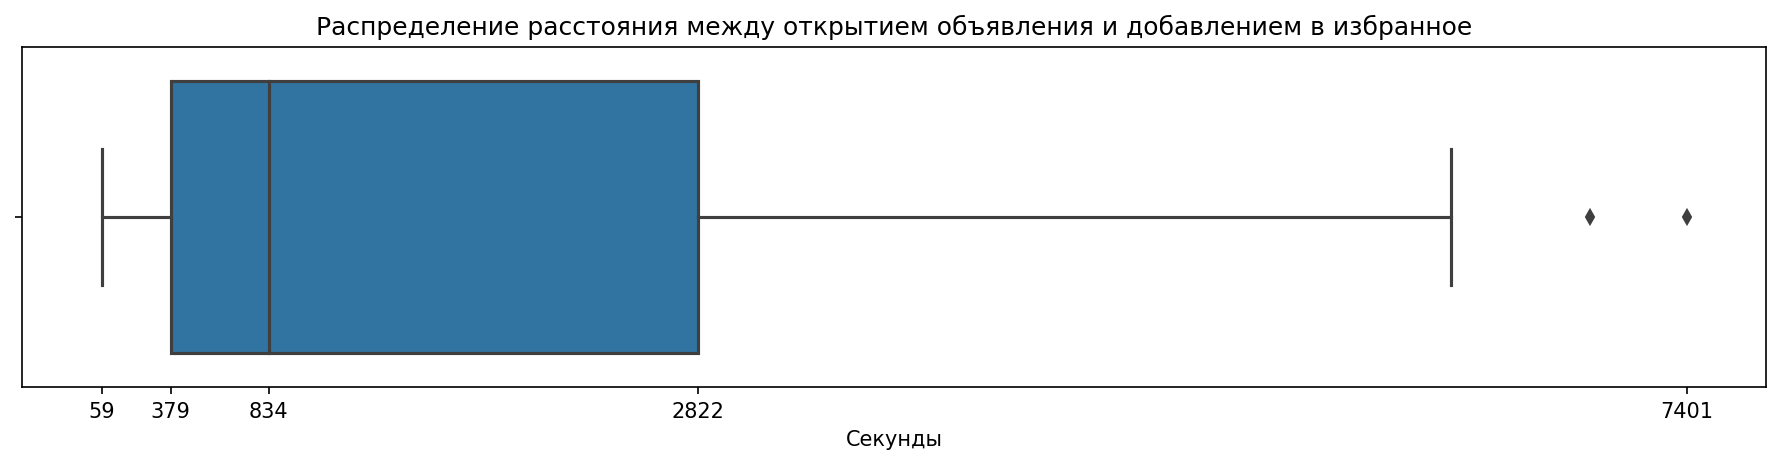

In [43]:
# построим диаграмму боксплот
fig, ax=plt.subplots(figsize=(15, 3), dpi=150)

ax = sns.boxplot(data=open_favorites, x= 'diff')
quantiles = np.quantile(open_favorites['diff'], np.array([0.00, 0.25, 0.50, 0.75, 1]))
ax.set_xticks(quantiles)

plt.title('Распределение расстояния между открытием объявления и добавлением в избранное')
plt.xlabel('Секунды');

Разброс значений находится в промежутке от 8 до 54 минут.

In [44]:
print('Медианное время между открытием объявления и добавлением в избранное: {} минут'.format(round(open_favorites['diff'].median()/ 60, 1)))

Медианное время между открытием объявления и добавлением в избранное: 13.9 минут


#### Просмотр фото - просмотр контактов `photos_show` - `contacts_show`

In [45]:
photos_contacts = time_between('photos_show', 'contacts_show')

print('Медианное время между просмотром фото объявления и просмотром контактов: {} минуты'.format(round(photos_contacts['diff'].median() / 60, 1)))


Медианное время между просмотром фото объявления и просмотром контактов: 7.9 минуты


In [46]:
# найдем 95 персентиль
perc_95 = np.percentile(photos_contacts['diff'], 95)
print('Меньше 5% данных составляют время {} часа'.format(round(perc_95/3600,1)))

Меньше 5% данных составляют время 3.7 часа


5% выбросов - это расстояние между событиями в более чем полтора часа. Отбросим этот хвост.


In [47]:
photos_contacts = photos_contacts.query('diff < @perc_95')


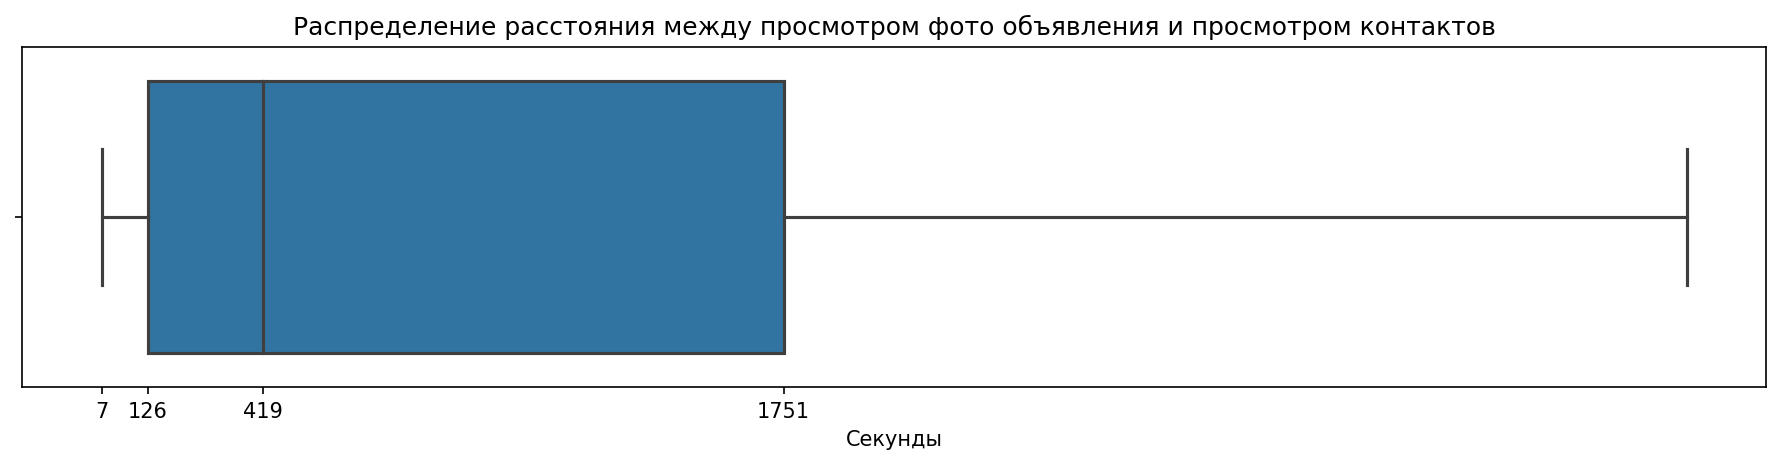

In [48]:
# построим диаграмму боксплот
fig, ax=plt.subplots(figsize=(15, 3), dpi=150)

ax = sns.boxplot(data=photos_contacts, x= 'diff', showfliers=False)
quantiles = np.quantile(photos_contacts['diff'], np.array([0.00, 0.25, 0.50, 0.75]))
ax.set_xticks(quantiles)

plt.title('Распределение расстояния между просмотром фото объявления и просмотром контактов')
plt.xlabel('Секунды');

Разброс значений находится в промежутке от 2,5 до 38 минут.

In [49]:
print('Медианное время между просмотром фото объявления и просмотром контактов: {} минут'.format(round(photos_contacts['diff'].median() / 60, 1)))

Медианное время между просмотром фото объявления и просмотром контактов: 7.0 минут


#### Карта - добавление в избранное `map` - `tips_show`

In [50]:
map_contacts = time_between('map', 'tips_show')

print('Медианное время между просмотром карты и просмотром рекомендаций: {} минуты'.format(round(map_contacts['diff'].median() / 60, 1)))


Медианное время между просмотром карты и просмотром рекомендаций: 1.7 минуты


In [51]:
# найдем 95 персентиль
perc_95 = np.percentile(map_contacts['diff'], 95)
print('Меньше 5% данных составляют время {} минуты'.format(round(perc_95/60,1)))

Меньше 5% данных составляют время 13.6 минуты


5% выбросов - это расстояние между событиями в более чем полтора часа. Отбросим этот хвост.


In [52]:
map_contacts = map_contacts.query('diff < @perc_95')


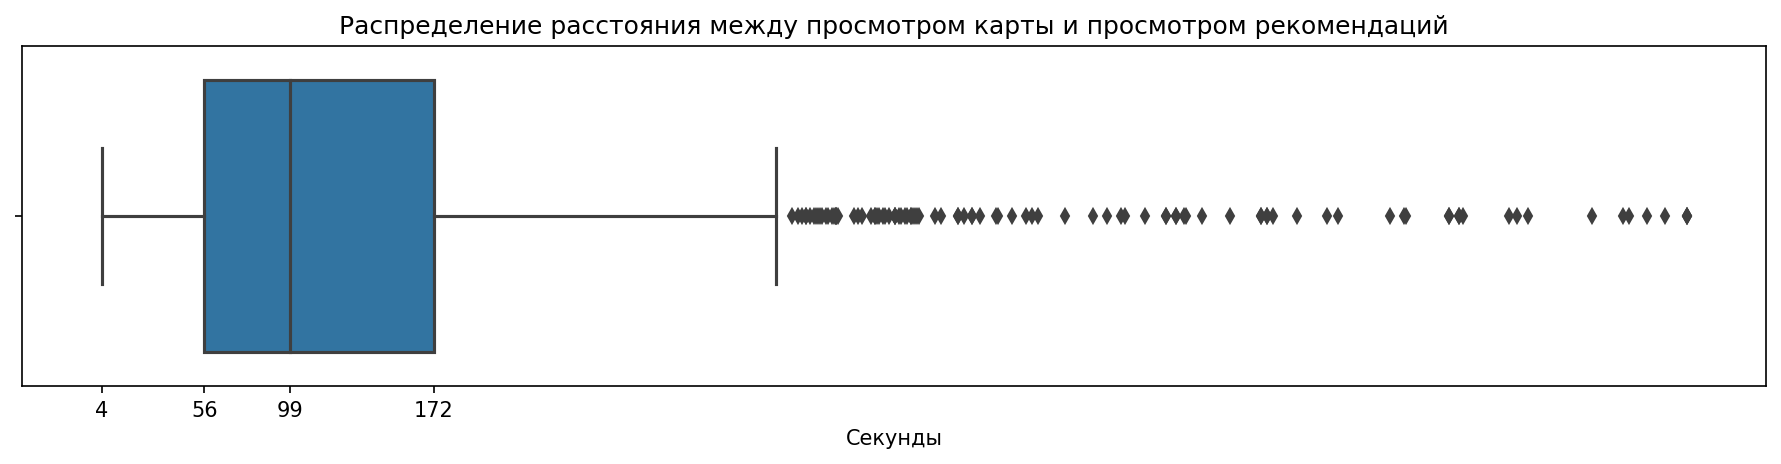

In [53]:
# построим диаграмму боксплот
fig, ax=plt.subplots(figsize=(15, 3), dpi=150)
ax = sns.boxplot(data=map_contacts, x= 'diff')
quantiles = np.quantile(map_contacts['diff'], np.array([0.00, 0.25, 0.50, 0.75]))
ax.set_xticks(quantiles)

plt.title('Распределение расстояния между просмотром карты и просмотром рекомендаций')
plt.xlabel('Секунды');

Разброс значений находится в промежутке от 1 до 3 минут.

In [54]:
print('Медианное время между просмотром карты и просмотром рекомендаций: {} минуты'.format(round(map_contacts['diff'].median() / 60, 1)))

Медианное время между просмотром карты и просмотром рекомендаций: 1.6 минуты


У нас получились следующие данные:  
- Медианное время между просмотром карты и добавлением в избранное: 11.25 минут.  
- Медианное время между открытием объявления и добавлением в избранное: 13.9 минут.  
- Медианное время между просмотром фото объявления и просмотром контактов: 7.0 минут.  
- Медианное время между просмотром карты и просмотром рекомендаций: 1.6 минуты.

Можно предположить, что алгоритм приложения показывает рекомендации рядом при просмотре карты. Ближе всего к целевому действию просмотр фото объявления, среди тех кто приходит по этому пути, время между этими событиями занимает меньше 10 минут. Время между открытием объявления и добавлением в избранное чуть больше, что говорит о том, что между ними возможно есть еще много других действий, человек смотрит и выбирает и после этого добавляет понравившиеся объявления в избранное.

Сложно сделать вывод, что в приложении есть какие-то технические сложности, которые приводят к тому, что пользователи не доходят до целевого действия. А вот бы все мы ходили по магазинам только тогда когда нам действительно что-то нужно.

[Содержание](#0)

Разброс значений находится в промежутке от 8 до 54 минут.

## Подсчет метрик
<a id=4> </a>

### Какая доля пользователей совершила целевое действие

#### Сколько всего пользователей в логе?

In [55]:
print('В логе', data['user_id'].nunique(), 'пользователь')

В логе 4293 пользователь


#### Сколько в среднем событий приходится на пользователя? ( в разрезе сессий)

In [56]:
# посчитаем количество событий на пользователя и возьмем среднее
event_mean = data.groupby(['user_id','session_id'], as_index=False).agg({'event_name': 'count'})
event_nunique = data.groupby(['user_id','session_id'], as_index=False).agg({'event_name': 'nunique'})
display(event_mean['event_name'].describe())
display(event_nunique['event_name'].describe())
print('В среднем на пользователя приходится', round(event_mean['event_name'].mean()), 'событий')
print('В среднем на пользователя приходится', round(event_nunique['event_name'].mean()), 'уникальных события')



count    8242.000000
mean        8.857923
std        12.045331
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       384.000000
Name: event_name, dtype: float64

count    8242.000000
mean        1.854404
std         0.961792
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: event_name, dtype: float64

В среднем на пользователя приходится 9 событий
В среднем на пользователя приходится 2 уникальных события


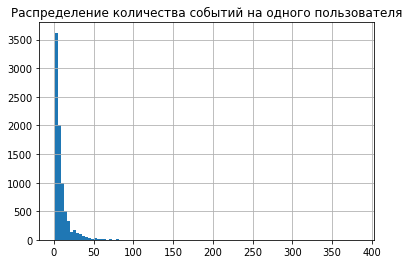

In [57]:
event_mean['event_name'].hist(bins=100)
plt.title('Распределение количества событий на одного пользователя');

Кажется, что в среднем пользователь совершает 9 уникальных событий, но если взглянуть на распределение, уидим, что в данных есть большие выборосы в расчете событий на одного пользователя - в основном они совершают от 2 до 5 событий, а события на сессию распределены более равномерно, о чем нам говорит величина стандартного отклонения меньше 1.

#### Целевое действие

In [58]:
# сколько пользователей совершили целевое действие - просмотр контактов
goal_users = data.query('event_name == "contacts_show"')['user_id'].nunique()
print('{} пользователей просмотрели контакты.'.format(goal_users))
print('Что составляет {}%'.format(round(goal_users/data['user_id'].nunique()*100, 2)))

981 пользователей просмотрели контакты.
Что составляет 22.85%


### DAU/WAU 

Конверсию будем считать так же в разрезе сессий. Поскольку сессии разделены по дням, мы выполним группировку по дням и вычислим число уникальных пользователей за каждый день - это наша метрика  DAU.

In [59]:
# выполним группировку по дням и посчитаем количество уникальных пользователей
dau = data.groupby([pd.Grouper(key='event_time',freq="D")]).agg({'user_id': 'nunique'}).reset_index()
print('Среднее количество посетителей сайта в день: {} человек'.format(round(dau['user_id'].mean())))

Среднее количество посетителей сайта в день: 279 человек


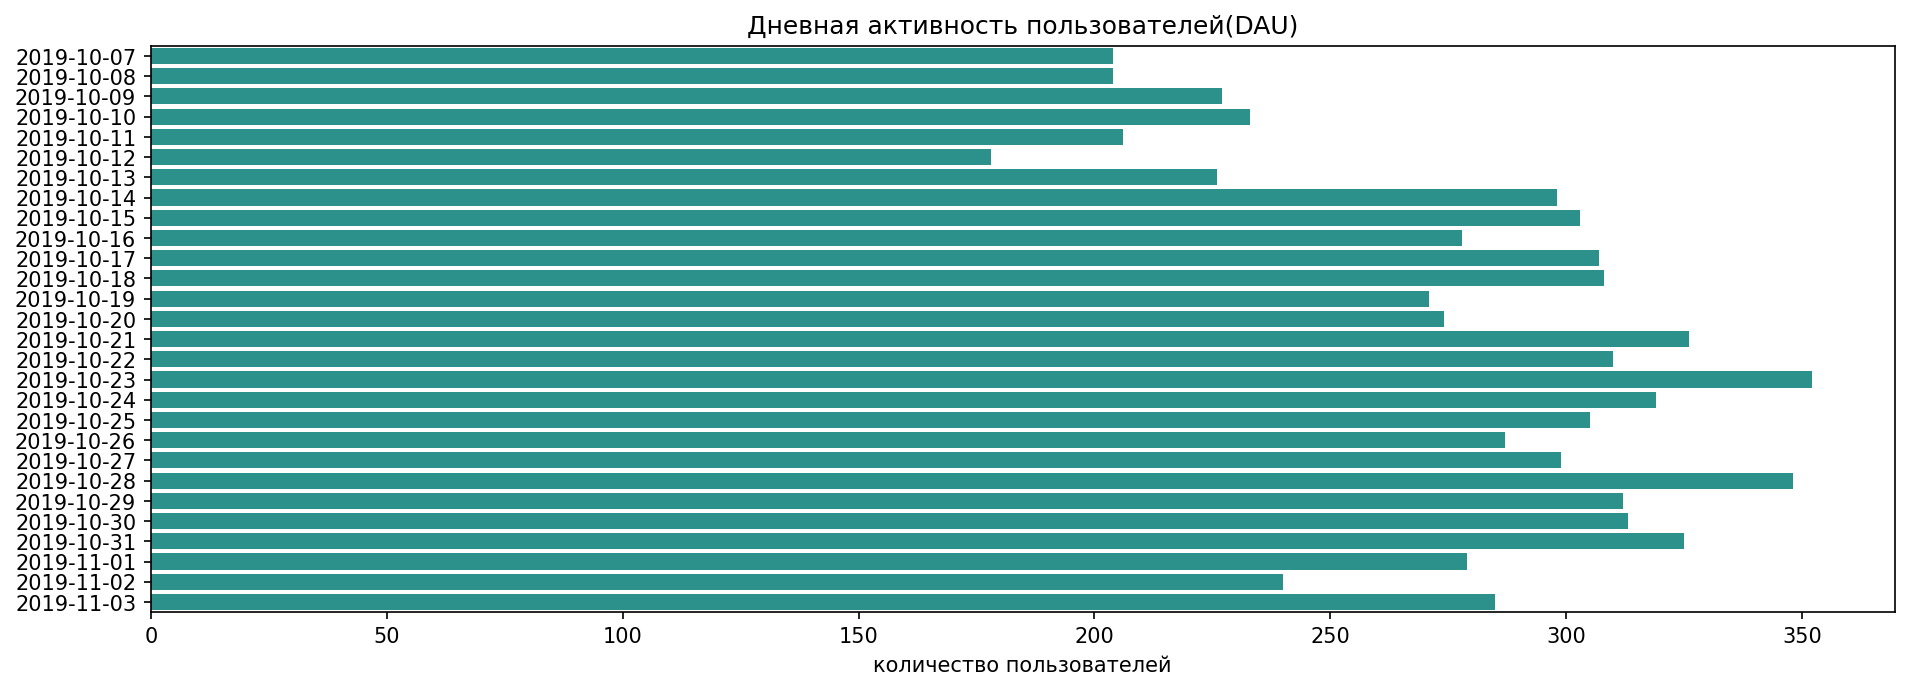

In [60]:
dau1 = dau.copy()
dau1['event_time'] = dau1['event_time'].astype(str)
f, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax = sns.barplot(data = dau1, x = 'user_id', y = 'event_time', color='#1CA09A')
plt.title('Дневная активность пользователей(DAU)')
plt.ylabel('')
plt.xlabel('количество пользователей')
plt.savefig('dau.png');


Так же посчитаем недельную активность.

In [61]:
# выполним группировку по неделям и посчитаем количество уникальных пользователей
wau = data.groupby([pd.Grouper(key='event_time',freq="W")]).agg({'user_id': 'nunique'}).reset_index()

print('Среднее количество посетителей сайта в неделю: {} человека'.format(round(wau['user_id'].mean())))

Среднее количество посетителей сайта в неделю: 1382 человека


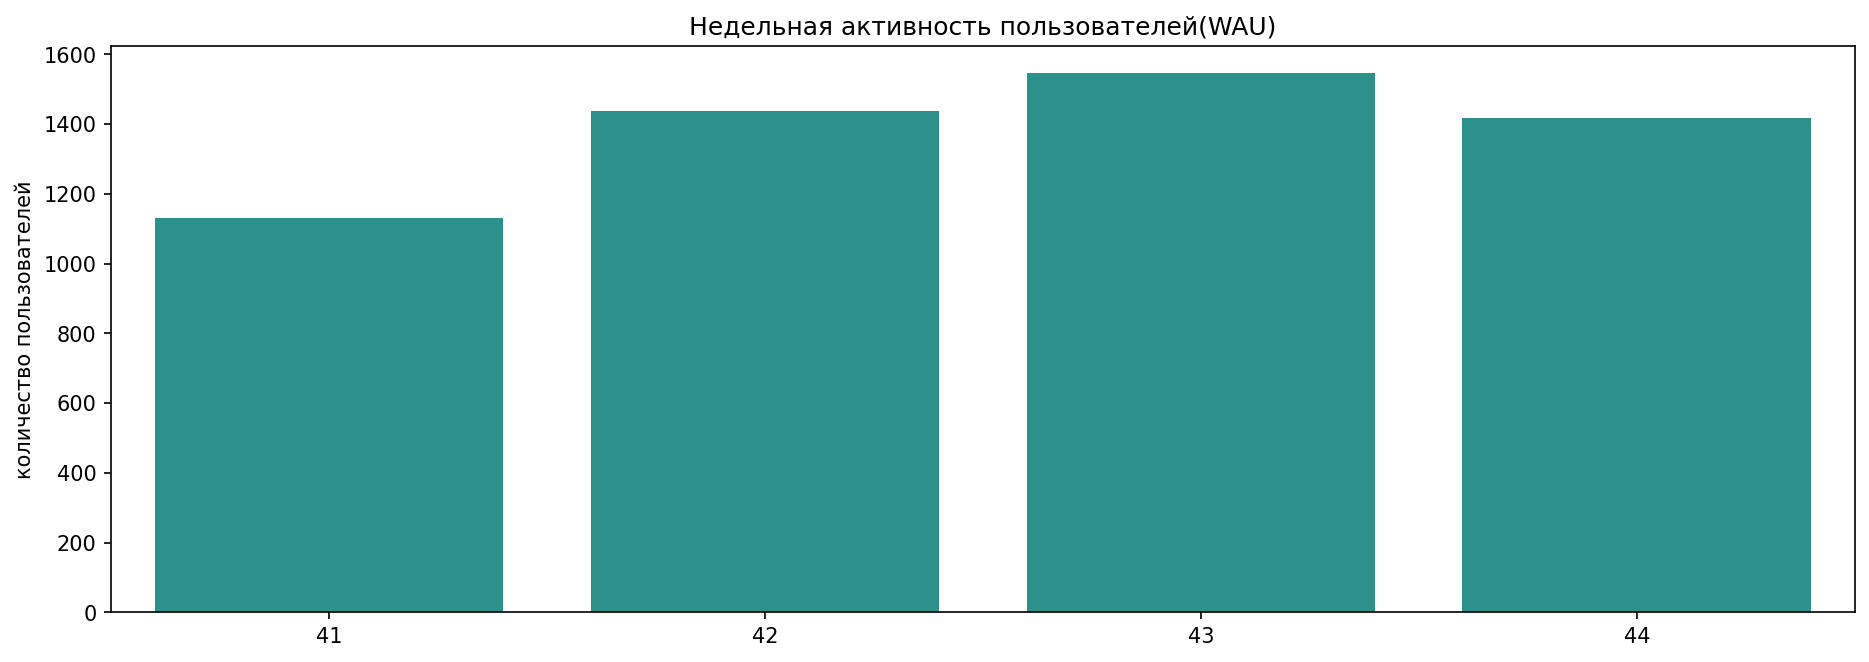

In [62]:
wau1 = wau.copy()
wau1['event_time'] = wau1['event_time'].apply(lambda x: x.isocalendar()[1])
f, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax = sns.barplot(data = wau1, y = 'user_id', x = 'event_time', color='#1CA09A')
plt.title('Недельная активность пользователей(WAU)')
plt.xlabel('')
plt.ylabel('количество пользователей')
plt.savefig('wau.png');

### Конверсия в целевое действие  

А теперь посмотрим, сколько из этих пользователей совершили целевое действие.

In [63]:
# выберем только интересующие нас событие
goal = data.query('event_name == "contacts_show"')

# выполним группировку по дням и посчитаем количество уникальных пользователей
d_goal = goal.groupby([pd.Grouper(key='event_time',freq="D")]).agg({'user_id': 'nunique'}).reset_index()
print('В среднем конверсия в целевое действие составила {}%'.format(round((d_goal['user_id']/dau['user_id']*100).mean(), 2)))


В среднем конверсия в целевое действие составила 18.35%


### Коэффициент удержания (Retention Rate)

Возьмем первую дату посещения и посмотрим на график динамики удержания.

In [64]:
# соберем самые ранние даты совершения события для каждого пользователя 
min_time = data.groupby('user_id').agg(min_time =('event_time', 'min')).reset_index()
min_time['min_time'] = min_time['min_time'].dt.date # оставим только дату, без времени
min_time
data = data.merge(min_time, on='user_id')
data

,event_time,event_name,user_id,source,session_id,min_time
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07
...,...,...,...,...,...,...
73002,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12
73003,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12
73004,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12
73005,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12


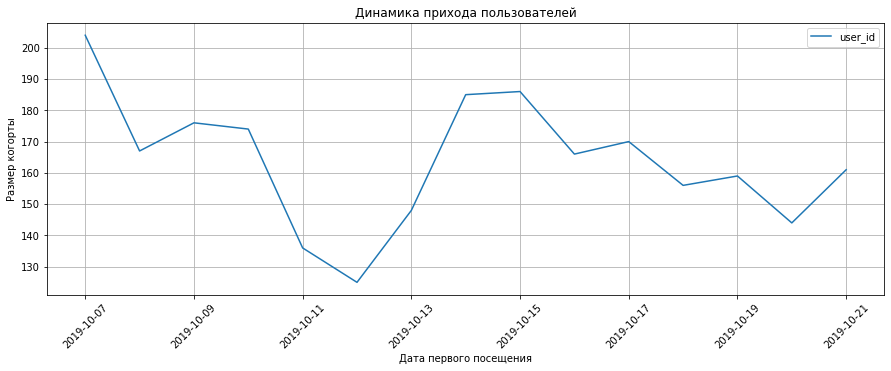

In [65]:
# определим доступный интервал
min_analysis_date = data['event_time'].min()
observation_date = data['event_time'].max()# ваш код здесь

# зададим горизонт анализа и посчитаем максимальную дату для исследования
analysis_horizon = 14 # ваш код здесь
max_analysis_date =  observation_date - timedelta(days=analysis_horizon - 1)# ваш код здесь

# рассчитаем размеры когорт
report = (
    data.query('@max_analysis_date >= event_time >= @min_analysis_date')  
    .groupby('min_time')
    .agg({'user_id': 'nunique'}) 
)
# построим график подключения пользователей к приложению
report.plot(figsize=(15,5), grid=True)  
plt.title('Динамика прихода пользователей')  
plt.xlabel('Дата первого посещения')  
plt.xticks(rotation=45)  
plt.ylabel('Размер когорты')   
plt.show()


Вычислим lifetime каждого пользователя.

Добавим в таблицу начало сессии, чтобы посчитать удержание.

In [66]:
session_start = data.groupby(['user_id', 'session_id']).agg(session_start =('event_time', 'min')).reset_index()
data = data.merge(session_start[['session_id', 'session_start']], on='session_id')
data['session_start'] = data['session_start'].dt.date
data

,event_time,event_name,user_id,source,session_id,min_time,session_start
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07
...,...,...,...,...,...,...,...
73002,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12,2019-11-03
73003,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12,2019-11-03
73004,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12,2019-11-03
73005,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,8242,2019-10-12,2019-11-03


In [67]:
# напишем функцию для вычисления удержания
def get_retention(
    df, observation_date, horizon_days, ignore_horizon = False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    result_raw = df.query('min_time <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['min_time']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['min_time'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('min_time')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    # объединяем размеры когорт и таблицу удержания

    result_grouped = cohort_sizes.merge(
        result_grouped, on='min_time', how='left'
    ).fillna(0)

    result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
    )

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

# задаём момент и горизонт анализа данных
observation_date = data['event_time'].max()
horizon_days = 14

# построим таблицу удержания
warnings.filterwarnings('ignore')
retention_raw, retention = get_retention(data, observation_date, analysis_horizon)# ваш код здесь

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
min_time,,,,,,,,,,,,,,,
2019-10-07,204,1.0,0.176471,0.102941,0.107843,0.063725,0.053922,0.039216,0.078431,0.063725,0.049020,0.068627,0.034314,0.019608,0.034314
2019-10-08,167,1.0,0.167665,0.119760,0.101796,0.035928,0.035928,0.065868,0.047904,0.065868,0.053892,0.059880,0.035928,0.017964,0.041916
2019-10-09,176,1.0,0.090909,0.085227,0.056818,0.056818,0.079545,0.056818,0.056818,0.056818,0.051136,0.022727,0.022727,0.039773,0.039773
2019-10-10,174,1.0,0.132184,0.074713,0.097701,0.074713,0.091954,0.063218,0.074713,0.063218,0.057471,0.040230,0.045977,0.045977,0.057471
2019-10-11,136,1.0,0.073529,0.073529,0.132353,0.095588,0.066176,0.058824,0.073529,0.022059,0.000000,0.051471,0.036765,0.044118,0.044118
2019-10-12,125,1.0,0.184000,0.120000,0.104000,0.064000,0.072000,0.104000,0.080000,0.072000,0.064000,0.064000,0.056000,0.048000,0.064000
2019-10-13,148,1.0,0.162162,0.087838,0.054054,0.074324,0.060811,0.040541,0.081081,0.047297,0.060811,0.013514,0.040541,0.020270,0.060811
2019-10-14,185,1.0,0.167568,0.086486,0.097297,0.097297,0.070270,0.048649,0.054054,0.054054,0.048649,0.037838,0.027027,0.037838,0.037838
2019-10-15,186,1.0,0.139785,0.096774,0.091398,0.059140,0.053763,0.064516,0.064516,0.086022,0.032258,0.043011,0.021505,0.026882,0.037634


Построим график удержания.

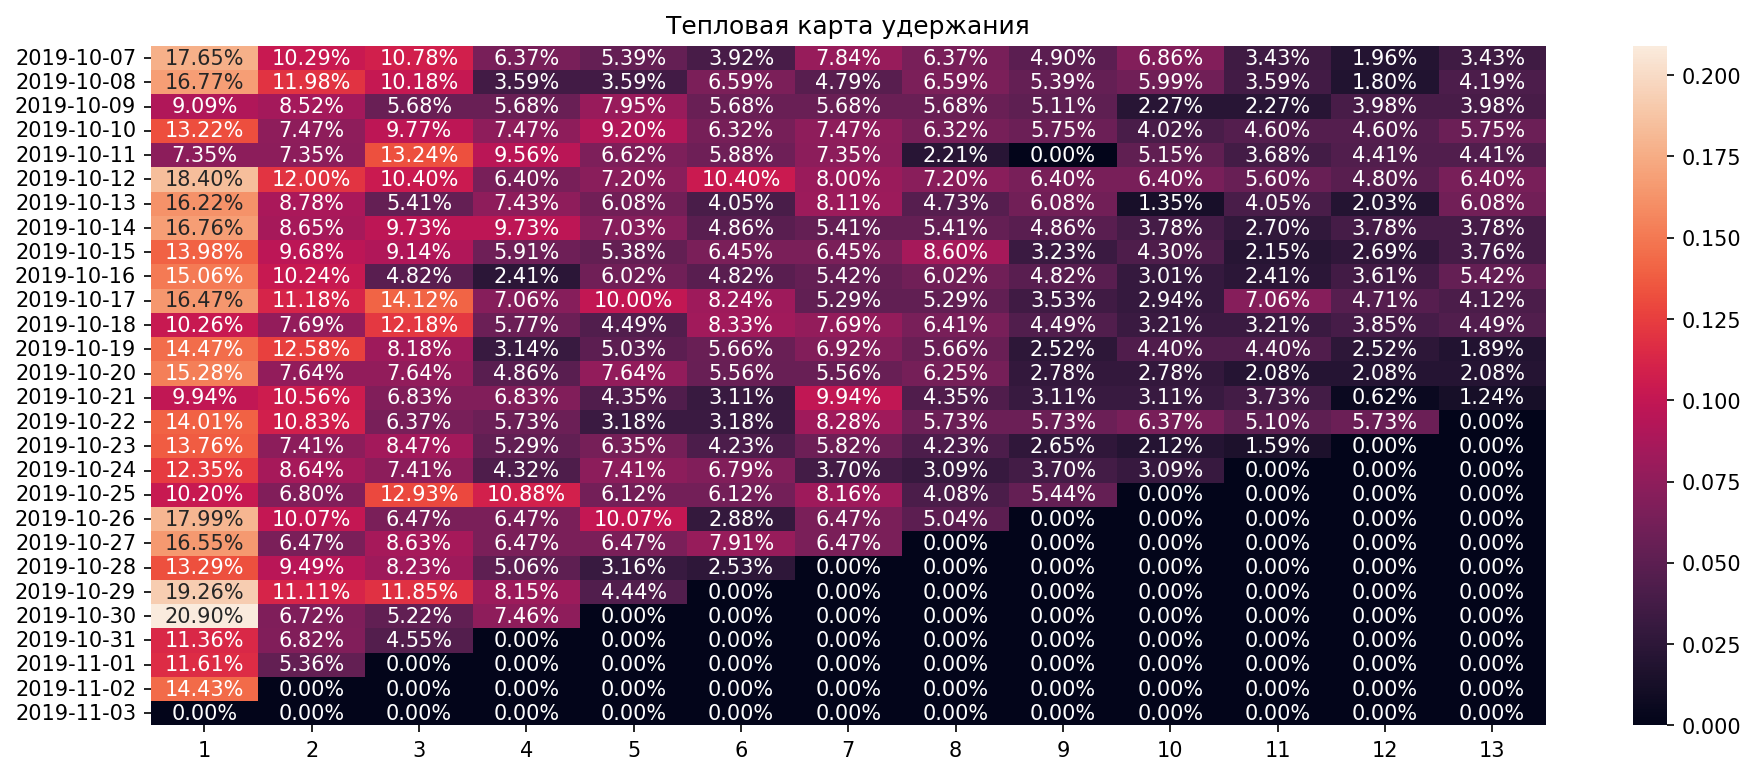

In [68]:
# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6), dpi=150)  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.savefig('heatmap_retention.png')
plt.ylabel('');

Видно, что всплески активности приходятся на каждые выходные, но невозможно выделить какие либо даты, когда пользователи лучше удерживались - все данные +- ровные и удержание стабильно низкое.

**Промужеточные выводы**

- Воронка событий, в которой присутствует карта с большей вероятностью приводит к целевому событию, чем просто поиск и просмотр объявлений, значит людям важно искать объявления поблизости.
- На конверсию в целевое действие так же влияет добавление в избранное.
- Судя по времени между между событиями, рекомендации показывают сразу после просмотра карты. Видимо это эффективный сценарий, приводящий к целевому действию.
- Люди чаще регистрируются и используют приложение по-выходным, но на удержание это не влияет.
- Среднее количество посетителей сайта в день: 279 человек.
- Среднее количество посетителей сайта в неделю: 1382 человека.


[Содержание](#0)

## Проверка гипотез
<a id=5> </a>

###  Гипотеза 1

$H^0$ Конверсия в целевое действие из `tips_show` и `tips_click` не отличается от конверсии из только `tips_show`. $H^1$ - конверсии значимо отличаются . Проверим при помощи z-теста по долям.

Найдем конверсию из `tips_show` в целевое  `contacts_show`. При этом надо удалить из числа этих пользователей тех, кто совершил еще и `tips_click`.


In [69]:
# напишем функцию, которая будет проверять равернство групп

def equal(successes, trials):
    alpha = .05 # критический уровень статистической значимости
  
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
        


In [70]:
# выделим пользователей, которые совершили tips_show, это будет первое значение trial
tips_users = data.query('event_name == "tips_show"')['user_id'].unique()
display(len(tips_users))
# а теперь те, кто совершил tips_show и вместе с ним еще и целевое contacts_show, это будет первое значение sucess

# из их числа нужно вычесть тех, кто совершил tips_click
click_users = data.query('event_name == "tips_click"')['user_id'].unique()
tips_contacts_users = data.query('user_id in @tips_users and user_id not in @click_users and event_name == "contacts_show"')['user_id'].unique()

display(len(tips_contacts_users))
print('Конверсия в целевое действие составила {}%'.format(round(len(tips_contacts_users)/len(tips_users)*100, 1)))

2801

425

Конверсия в целевое действие составила 15.2%


In [71]:
# выделим пользователей, которые совершили tips_show и tips_click, это будет второе значение trial
show_click_users = data.query('user_id in @tips_users and event_name == "tips_click"')['user_id'].unique()
display(len(show_click_users))

# а теперь те, кто совершил tips_show и вместе с ним еще и целевое contacts_show, это будет второе значение sucess
contacts_show_click_users = data.query('user_id in @show_click_users and event_name == "contacts_show"')['user_id'].unique()
display(len(contacts_show_click_users)) 
print('Конверсия в целевое действие составила {}%'.format(round(len(contacts_show_click_users)/len(show_click_users)*100, 1)))


297

91

Конверсия в целевое действие составила 30.6%


In [72]:
# применим нашу функцию, чтобы сравнить группы
successes = np.array([len(tips_contacts_users), len(contacts_show_click_users)])
trials = np.array([len(tips_users), len(show_click_users)])
equal(successes, trials)

p-значение:  1.0283995877102825e-11
Отвергаем нулевую гипотезу: между долями есть значимая разница.


На основании статистического теста мы можем сказать, что конверсия в целевое действие из tips_show и tips_click отличается от конверсии только из tips_show.

### Гипотеза 2

Пользователи, совершившие действие `favorites_add` лучше конвертируются в целевое действие, чем те у кого его нет.   
$H^0$ - конверсия в целевое действие из `favorites_add` такая же как у пользователей, не совершивших это событие.  
$H^1$ - конверсия отличается.
Для проверки искользуем тот же тест.

In [73]:
# выделим пользователей, которые совершили favorites_add, это будет первое значение trial
fave_users = data.query('event_name == "favorites_add"')['user_id'].unique()
display(len(fave_users))
# а теперь те, кто совершил tips_show и вместе с ним еще и целевое contacts_show, это будет первое значение sucess

fave_contacts_users = data.query('user_id in @fave_users and event_name == "contacts_show"')['user_id'].unique()
display(len(fave_contacts_users)) 
print('Конверсия в целевое действие составила {}%'.format(round(len(fave_contacts_users)/len(fave_users)*100, 1)))


351

136

Конверсия в целевое действие составила 38.7%


А теперь проверим конверсию пользователей, которые совершили целевое действие, но при этом не добавили объявления в избранное.

In [74]:
# вычтем из чиала всех пользователей тех, кто совершил favorites_add, это будет второе значение trial
no_fave_users = data.query('user_id not in @fave_users')['user_id'].unique()
display(len(no_fave_users)) 
# а теперь выберем из их числа тех, кто совершил целевое действие - это будет второе значение sucess
no_fave_contacts_users = data.query('user_id in @no_fave_users and event_name == "contacts_show"')['user_id'].unique()
display(len(no_fave_contacts_users)) 
print('Конверсия в целевое действие составила {}%'.format(round(len(no_fave_contacts_users)/len(no_fave_users)*100, 1)))


3942

845

Конверсия в целевое действие составила 21.4%


Применим статистический тест для проверки.

In [75]:
# применим нашу функцию, чтобы сравнить группы
successes = np.array([len(fave_contacts_users), len(no_fave_contacts_users)])
trials = np.array([len(fave_users), len(no_fave_users)])
equal(successes, trials)

p-значение:  1.3455903058456897e-13
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Видим что и вторая гипотеза подтвердилась: с большой долей вероятности пользователи, добавившие в избранное объявление, лучше конвертируются в целевое действие.

[Содержание](#0)

## Вывод
<a id=6> </a>

Мы изучили предоставленные заказчиком данные о логах мобильного приложения.  
После обработки данных мы установили что располагаем данными с 7 октября 2019 по 3 ноября 2019 то есть примерно 4 недели. Данные полные.  

События, совершаемые пользователями, складываются в несколько характерных сценариев, которые либо заканчиваются целевым событием - просмотром контактов, либо - возвращением к просмотру рекомендаций.  
Вот самые распространенные сценарии:  
- просмотр рекомендаций, просмотр контактов
- карта, просмотр рекомендаций, просмотр контактов
- поиск, просмотр фото, просмотр контактов

- поиск, карта, просмотр рекомендаций
- поиск, карта, открытие карточки объявления, просмотр рекомендаций
- карта, открытие карточки объявления, просмотр рекомендаций

В исследовании мы проиллюстрировани данные сценарии воронками.  

Для того, чтобы проследить корреляцию с целевым действием, мы построили тепловую карту, которая еще раз продемонстрировала, что бОльшая часть людей просто приходят посмотреть картинки, и до целевого действия не доходят. Показ рекомендаций по геолокации помогает пользователем найти то что нужно и повышает конверсию.

Мы измерили время между распространенными парами событий в логе. На основании полученных данных можно предположить, что скорее всего алгоритм приложения показывает рекомендации рядом при просмотре карты. И что поиск часто не приводит к тому, что пользователь находит что-то что ему нужно, и как следствие - он даже не заходит в карточку контакта. Так же мы установили что, если пользователь добавил объявление в избранное, он с большой долей вероятности совршит целевое действие.

Далее мы проанализировали основные бизнес-метрики и выяснили:
- среднее количество посетитиелей сайта в день: 279 человек
- среднее количество посетитиелей сайта в неделю: 1382 человека
- в среднем конверсия в целевое действие составила 18.35%  

Так же мы построили тепловую карту и линейный график удержания, и выяснили что в данных нет каких-либо всплесков деятельности, что в общем логично, потому что мы не рассматриваем тестирование какой-либо фичи или какие-либо события, которые могли бы вызвать всплески в данных.

Мы проверили гипотезу 1: одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Конверсия в просмотры контактов различается у этих двух групп. Гипотеза подтвердилась: пользователи кликающие объявление лучше конвертируются в просмотр контактов.

Мы так же проверили гипотезу 2: пользователи, совершившие действие favorites_add лучше конвертируются в целевое действие, чем те у кого его нет, и она тоже подтвердилась, действительно, добавление в избранное значительно повышает вероятность просмотра контактов.

На основе проведенного исследования можно предложить разработчикам следующие рекомендации по улучшению приложения:

1. Всего 18% из тех кто смотрит рекомендации доходит до целевого действия, что соответствует общей конверсии приложения - показ рекомендаций никак не стимулирует пользователей к покупке, скорее всего его механизм не отработан и его нужно исправить. 
2. Поскольку поиск объявлений по геолокации повышает конверсию, можно предложить соответствующим образом настроить механизм рекомендаций, чтобы пользователю показывались объявления поблизости.
3. Поскольку добавление в избранное так же повышает конверсию, можно сделать напоминания или вывести избранное в более удобный доступ на главное странице.
4. Мы так же установили что пользователи чаще скачивают пришложение и начинают им пользоваться в выходные дни, стоит поработать над удержанием, например добавив рекламу или интересные акции, которые смогут увлечь пользователей и создать ага-момент.

Дополнительно можно рассмотреть разницу в конверсии источников.
